### Marius Casamian / L3 IA PROJET
### Objectifs: Probleme de classification binaire, demande de prêt approuvé ou non
### Compte-Rendu en pièce jointe dans le projet
### PS: Notebook effectuer seul le plus possible pour évaluer mon vrai niveau à travers ce défi et connaître mes points forts et faibles ainsi que ma marge de progression!

In [1]:
#Installation de PyTorch
!pip install torch --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [3]:
#importation des modules obligatoires
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn

In [5]:
# Partie 1: comprendre les données

df = pd.read_csv('/home/m1000/Bureau/playground-series-s4e10/train.csv')

del df['id'] #on supprime id car inutile pour le jeu de données train
# Vérification que la cible est binaire
assert set(df['loan_status'].unique()) == {0,1}, "La cible doit être strictement binaire."
missing_percentage = df.isnull().sum() * 100 / len(df)
print(f"The missing_percentage is around: {missing_percentage}\n") #pourcentage de valeurs manquantes


The missing_percentage is around: person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
loan_status                   0.0
dtype: float64



In [7]:
#Dans cette cellule, on regarde les valeurs uniques (différentes) pour chaques features
unique = df.nunique().sort_values()
unique_values = df.apply(lambda x: x.unique())
result = pd.DataFrame({
    'Number of Unique Values': unique, 
    'Unique Values': unique_values
})
result

,Number of Unique Values,Unique Values
cb_person_cred_hist_length,29,"[14, 2, 10, 5, 3, 11, 6, 9, 7, 8, 4, 17, 13, 1..."
cb_person_default_on_file,2,"[N, Y]"
loan_amnt,545,"[6000, 4000, 12000, 9000, 2500, 5000, 15000, 1..."
loan_grade,7,"[B, C, A, D, E, F, G]"
loan_int_rate,362,"[11.49, 13.35, 8.9, 11.11, 6.92, 8.94, 6.54, 1..."
loan_intent,6,"[EDUCATION, MEDICAL, PERSONAL, VENTURE, DEBTCO..."
loan_percent_income,61,"[0.17, 0.07, 0.21, 0.1, 0.2, 0.27, 0.13, 0.14,..."
loan_status,2,"[0, 1]"
person_age,53,"[37, 22, 29, 30, 27, 25, 21, 35, 31, 26, 28, 3..."
person_emp_length,36,"[0.0, 6.0, 8.0, 14.0, 2.0, 9.0, 11.0, 5.0, 1.0..."


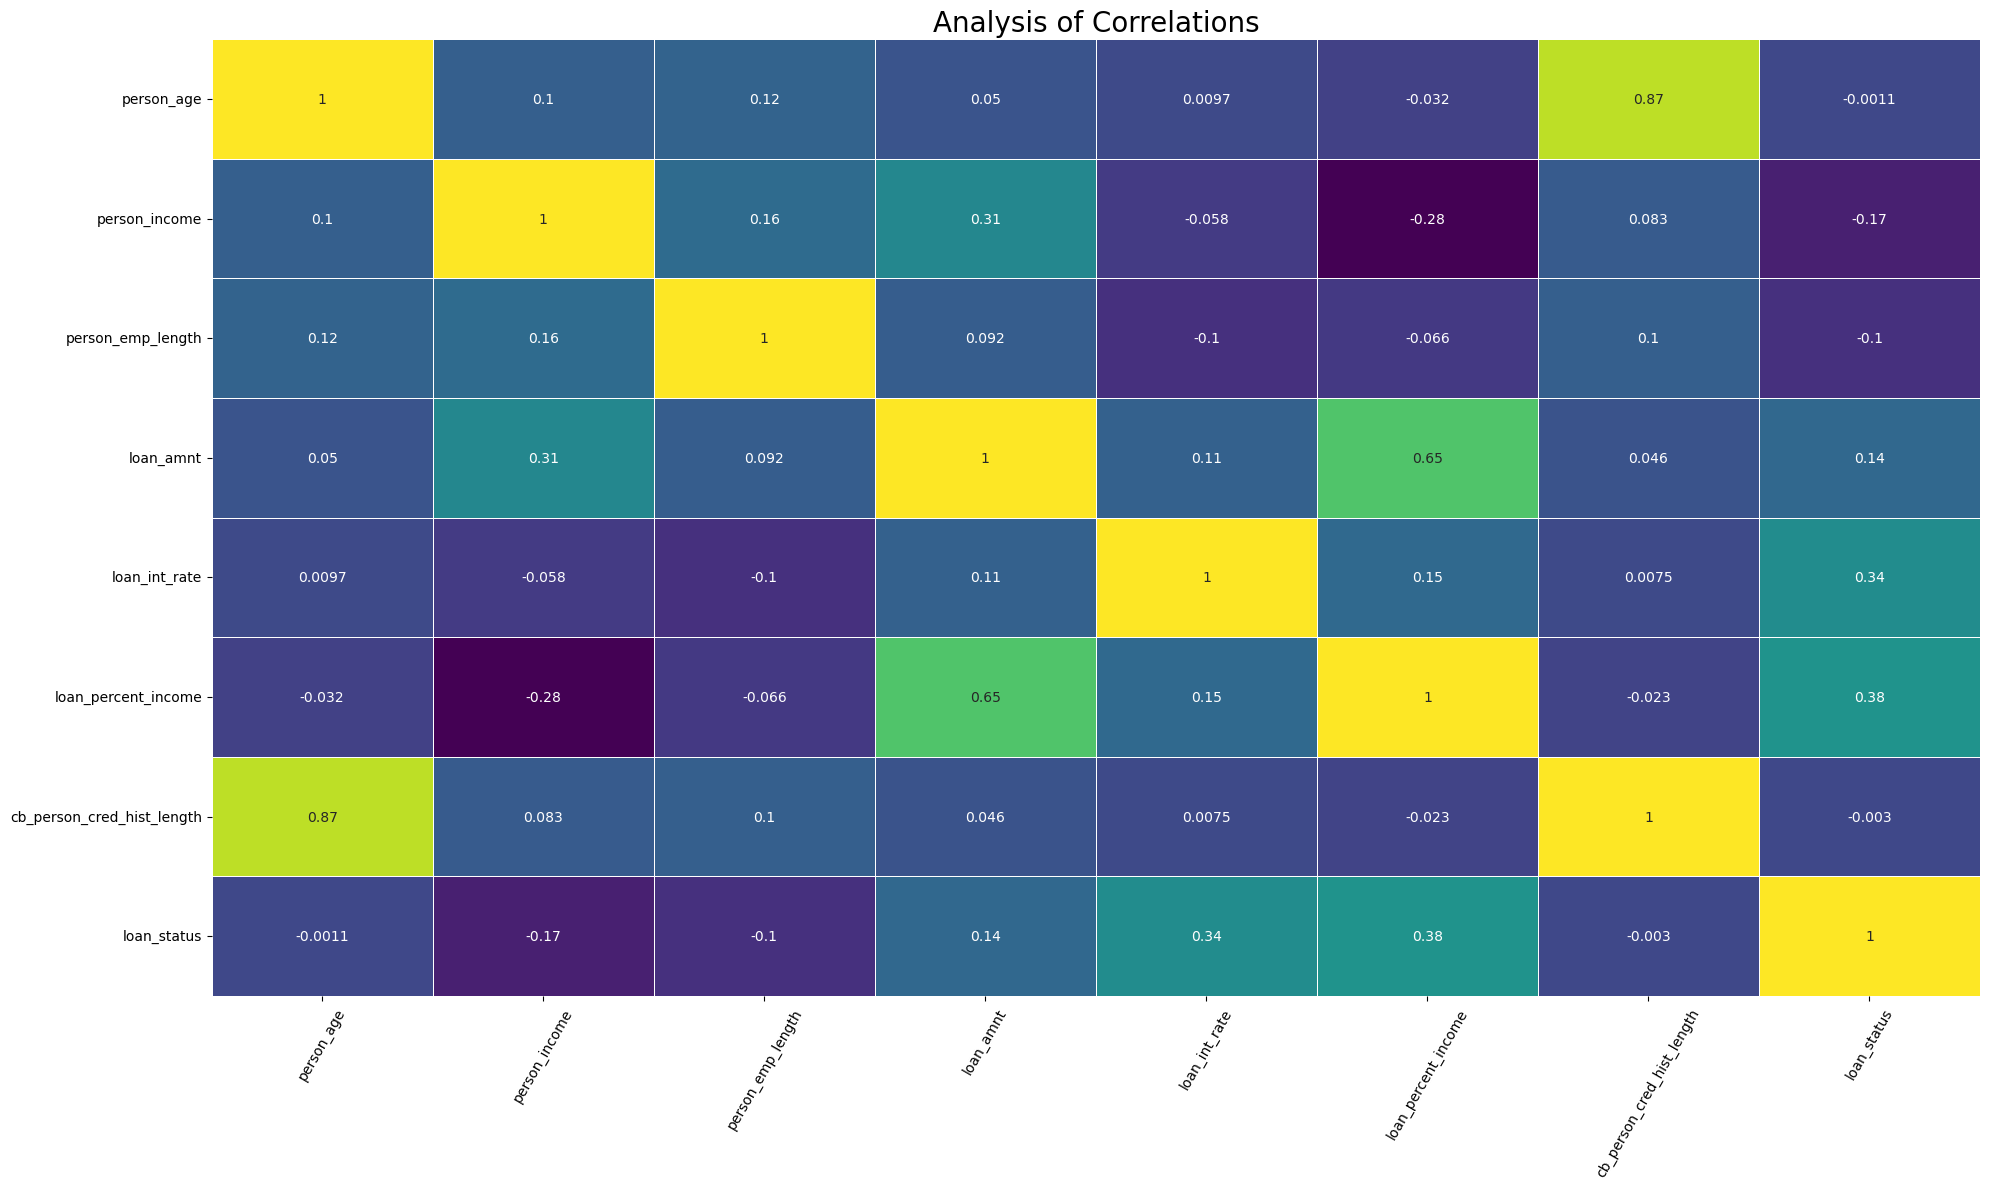

In [9]:
#la heatmap permet de mieux voir quelles sont les features corrélées, pour décider ou non d'une modification 
plt.figure(figsize=(20, 12))
sns.heatmap(
    df.corr(numeric_only=True), 
    cmap="viridis", 
    annot=True, 
    linewidths=.6, 
    cbar=False
)
plt.xticks(rotation=60, size=10)
plt.yticks(size=10)
plt.title('Analysis of Correlations', size=20)
plt.tight_layout()
plt.show()

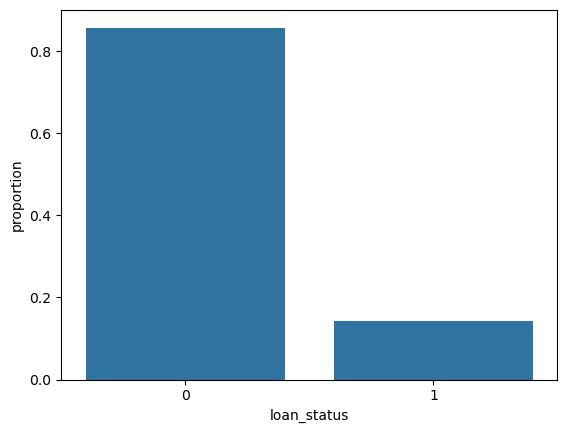

In [11]:
#proportion de prêt acceptés et refusés
loan_status_distribution = df['loan_status'].value_counts(normalize=True).reset_index() #compte les valeurs
loan_status_distribution.columns = ['loan_status', "proportion"]
fig = sns.barplot(
    data = loan_status_distribution,
    x='loan_status',
    y='proportion',
)

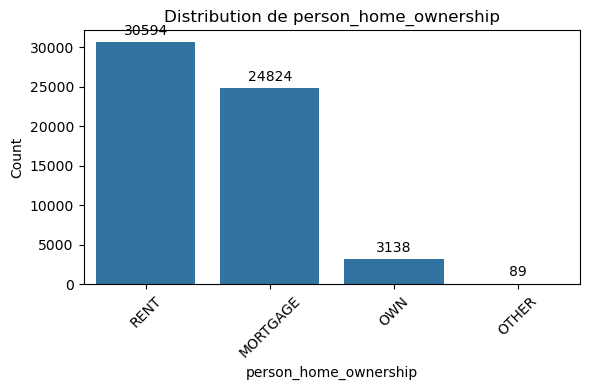

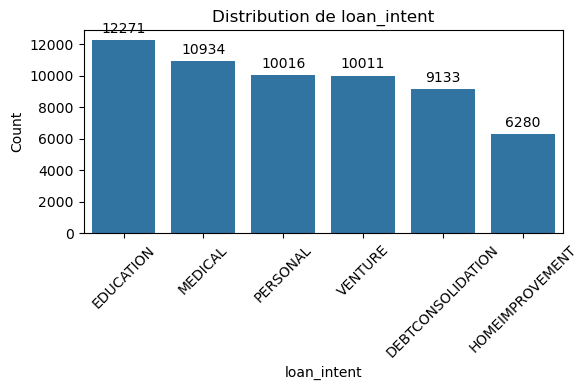

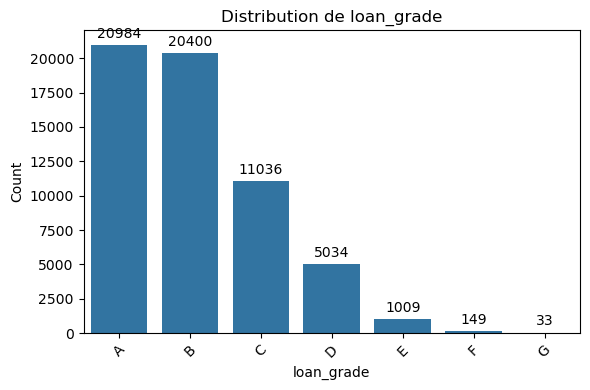

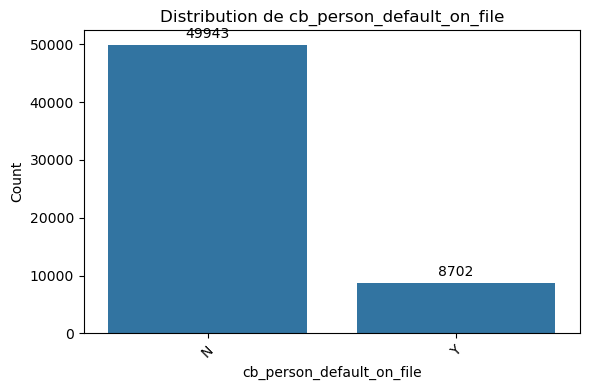

In [13]:
#selection des variables catégoriques
categorical_columns = [
    'person_home_ownership', 
    'loan_intent', 
    'loan_grade', 
    'cb_person_default_on_file'
]

for column in categorical_columns:
    value_counts = df[column].value_counts().reset_index()
    value_counts.columns = [column, 'Count']

    plt.figure(figsize=(6,4))
    ax = sns.barplot(
        data=value_counts,
        x=column,
        y='Count'
    )
    ax.set_title(f"Distribution de {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Count")
    plt.xticks(rotation=45)

    # Ajouter la valeur au-dessus de chaque barre pour plus de visibilité
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(p.get_x() + p.get_width()/2, height),
                    xytext=(0, 3), # léger décalage vertical
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


In [15]:
#calcul de la distribution pour chaque type de prêts en fonction de chaques types de maisons
home_ownership_dist = df.groupby('person_home_ownership')['loan_status'].value_counts(normalize=True).unstack().fillna(0)
home_ownership_dist = home_ownership_dist.applymap(lambda x: f"{x * 100:.2f}%") # Convertit les proportions en pourcentages et les formate avec deux décimales.
print(home_ownership_dist)

loan_status                 0       1
person_home_ownership                
MORTGAGE               94.03%   5.97%
OTHER                  83.15%  16.85%
OWN                    98.63%   1.37%
RENT                   77.74%  22.26%


/tmp/ipykernel_29789/674619004.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  home_ownership_dist = home_ownership_dist.applymap(lambda x: f"{x * 100:.2f}%") # Convertit les proportions en pourcentages et les formate avec deux décimales.


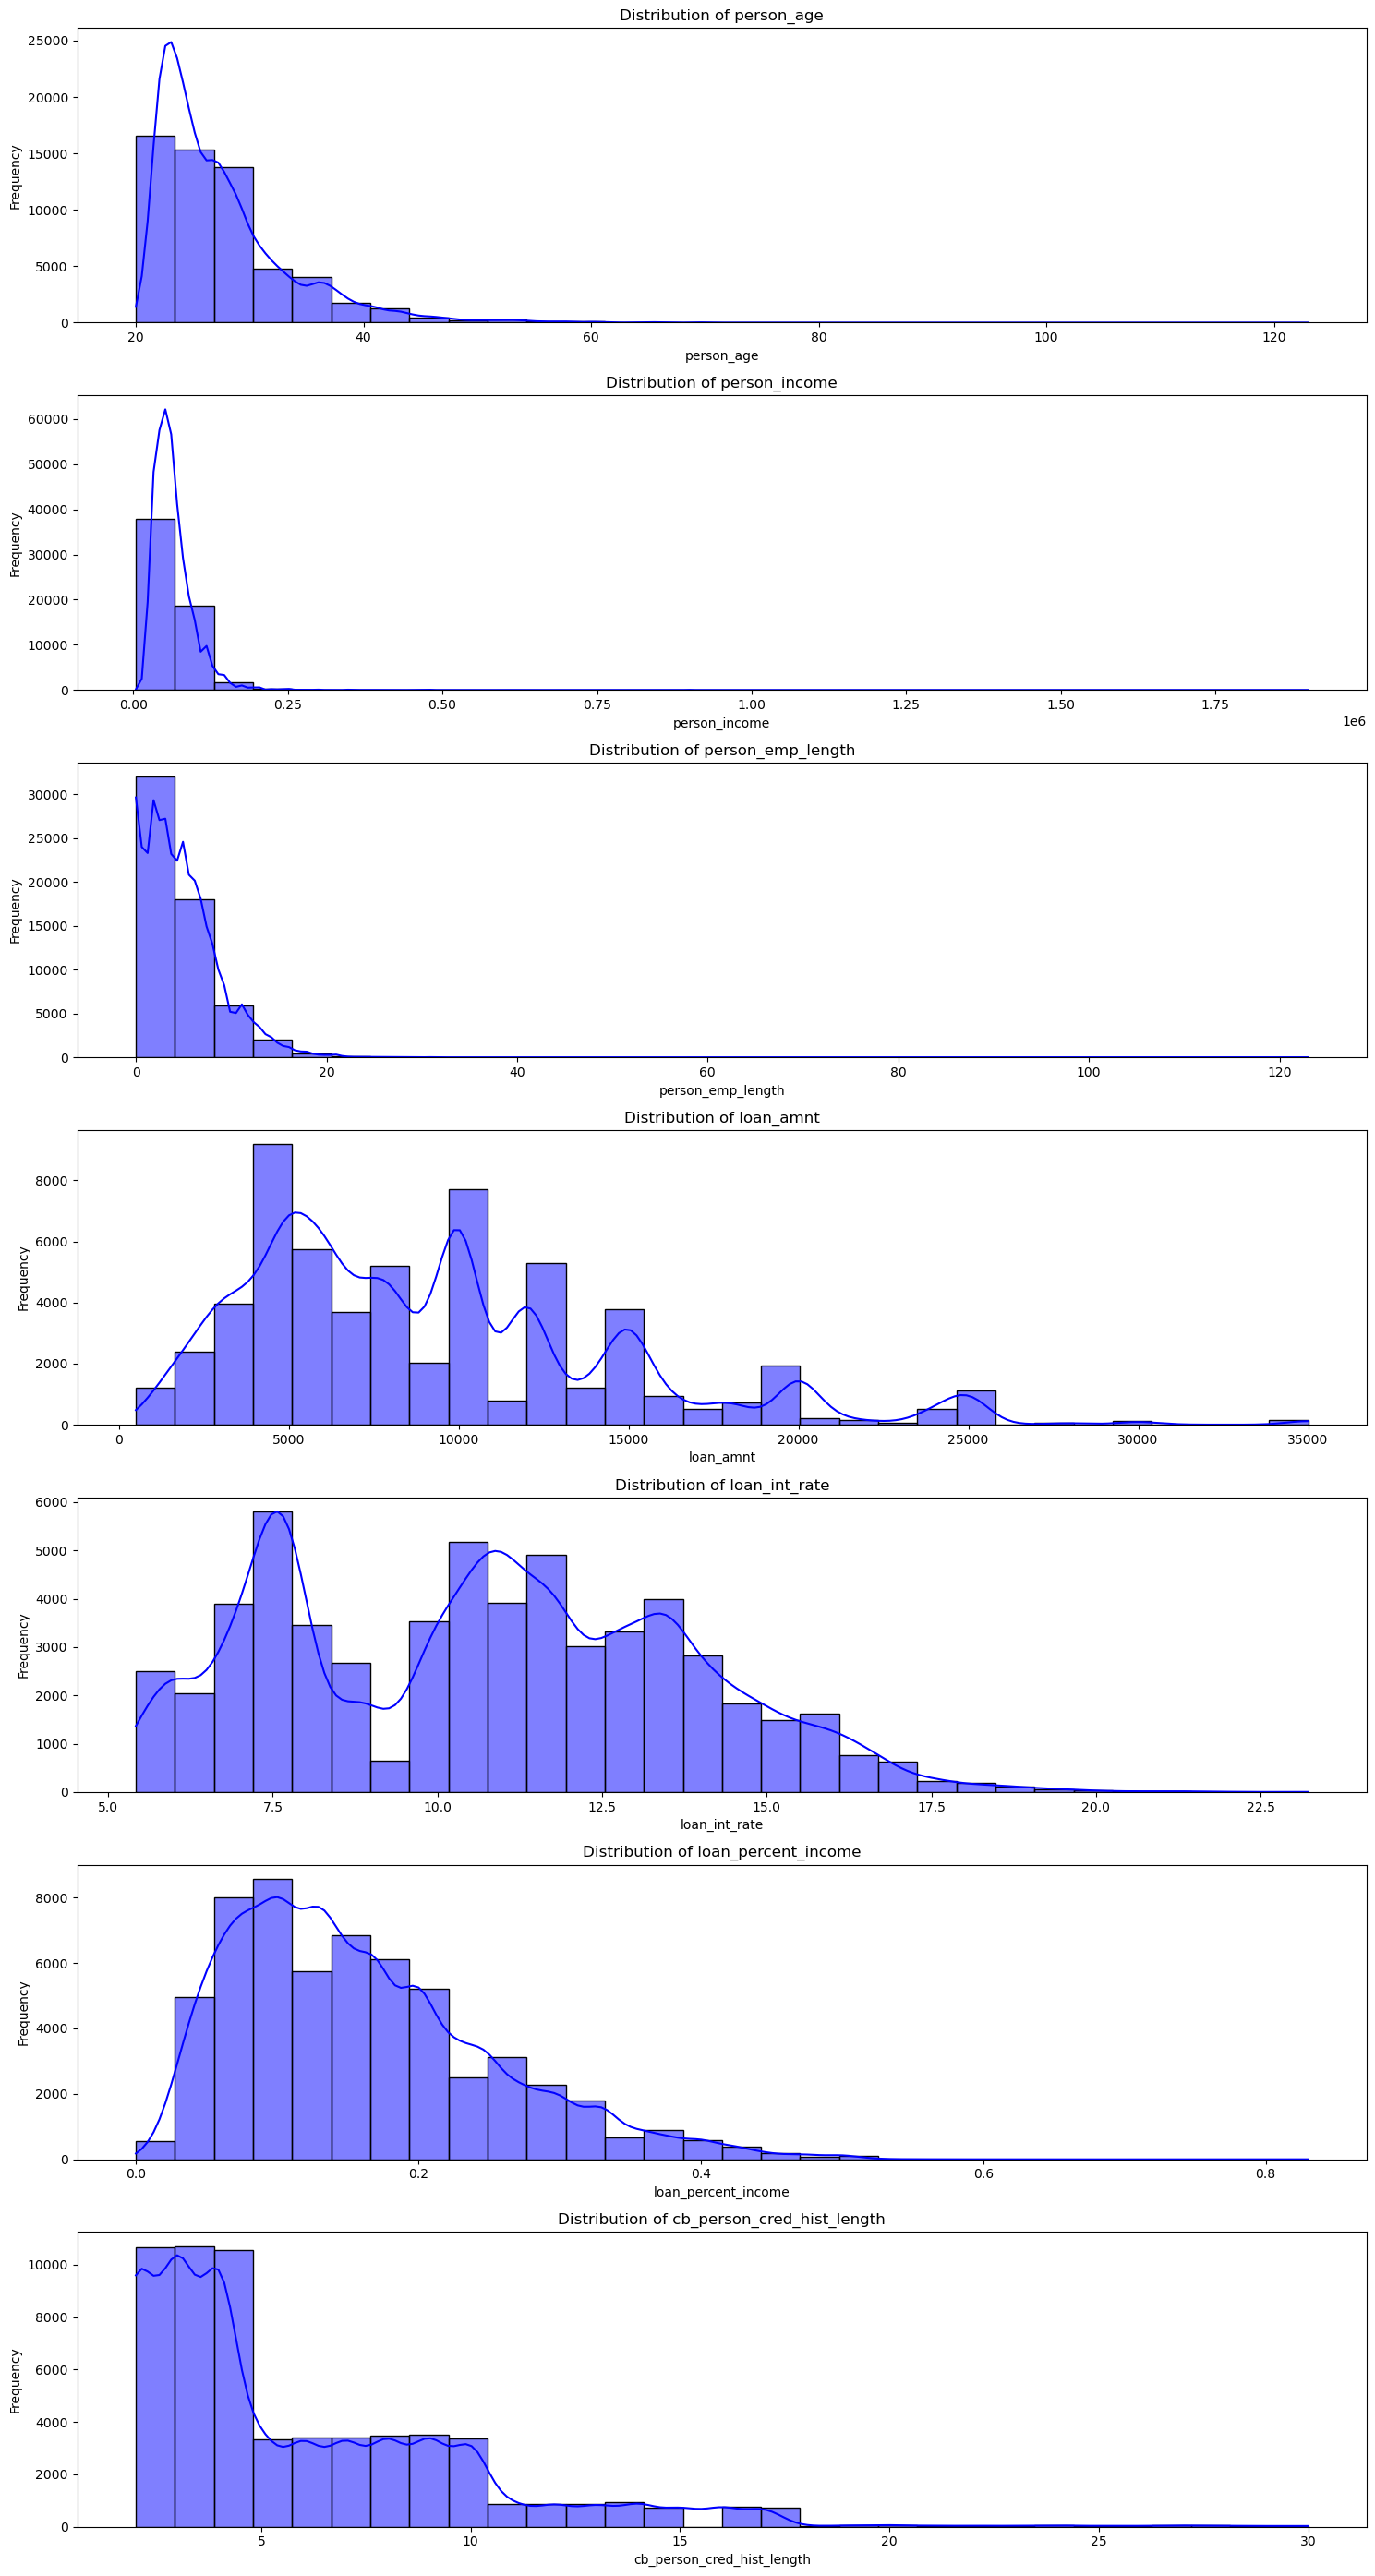

In [17]:
numerical_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col != 'loan_status'] #vient chercher les colonnes numériques sans la feature cible
plt.figure(figsize=(15, len(numerical_cols) * 4)) # prépare chaque cadre
for i, col in enumerate(numerical_cols, 1): #boucle sur chaque numerical features 
    plt.subplot(len(numerical_cols), 1, i)
    sns.histplot(df[col], kde=True, bins=30, color='blue') # donne l'histogramme correspond à la feature de i
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


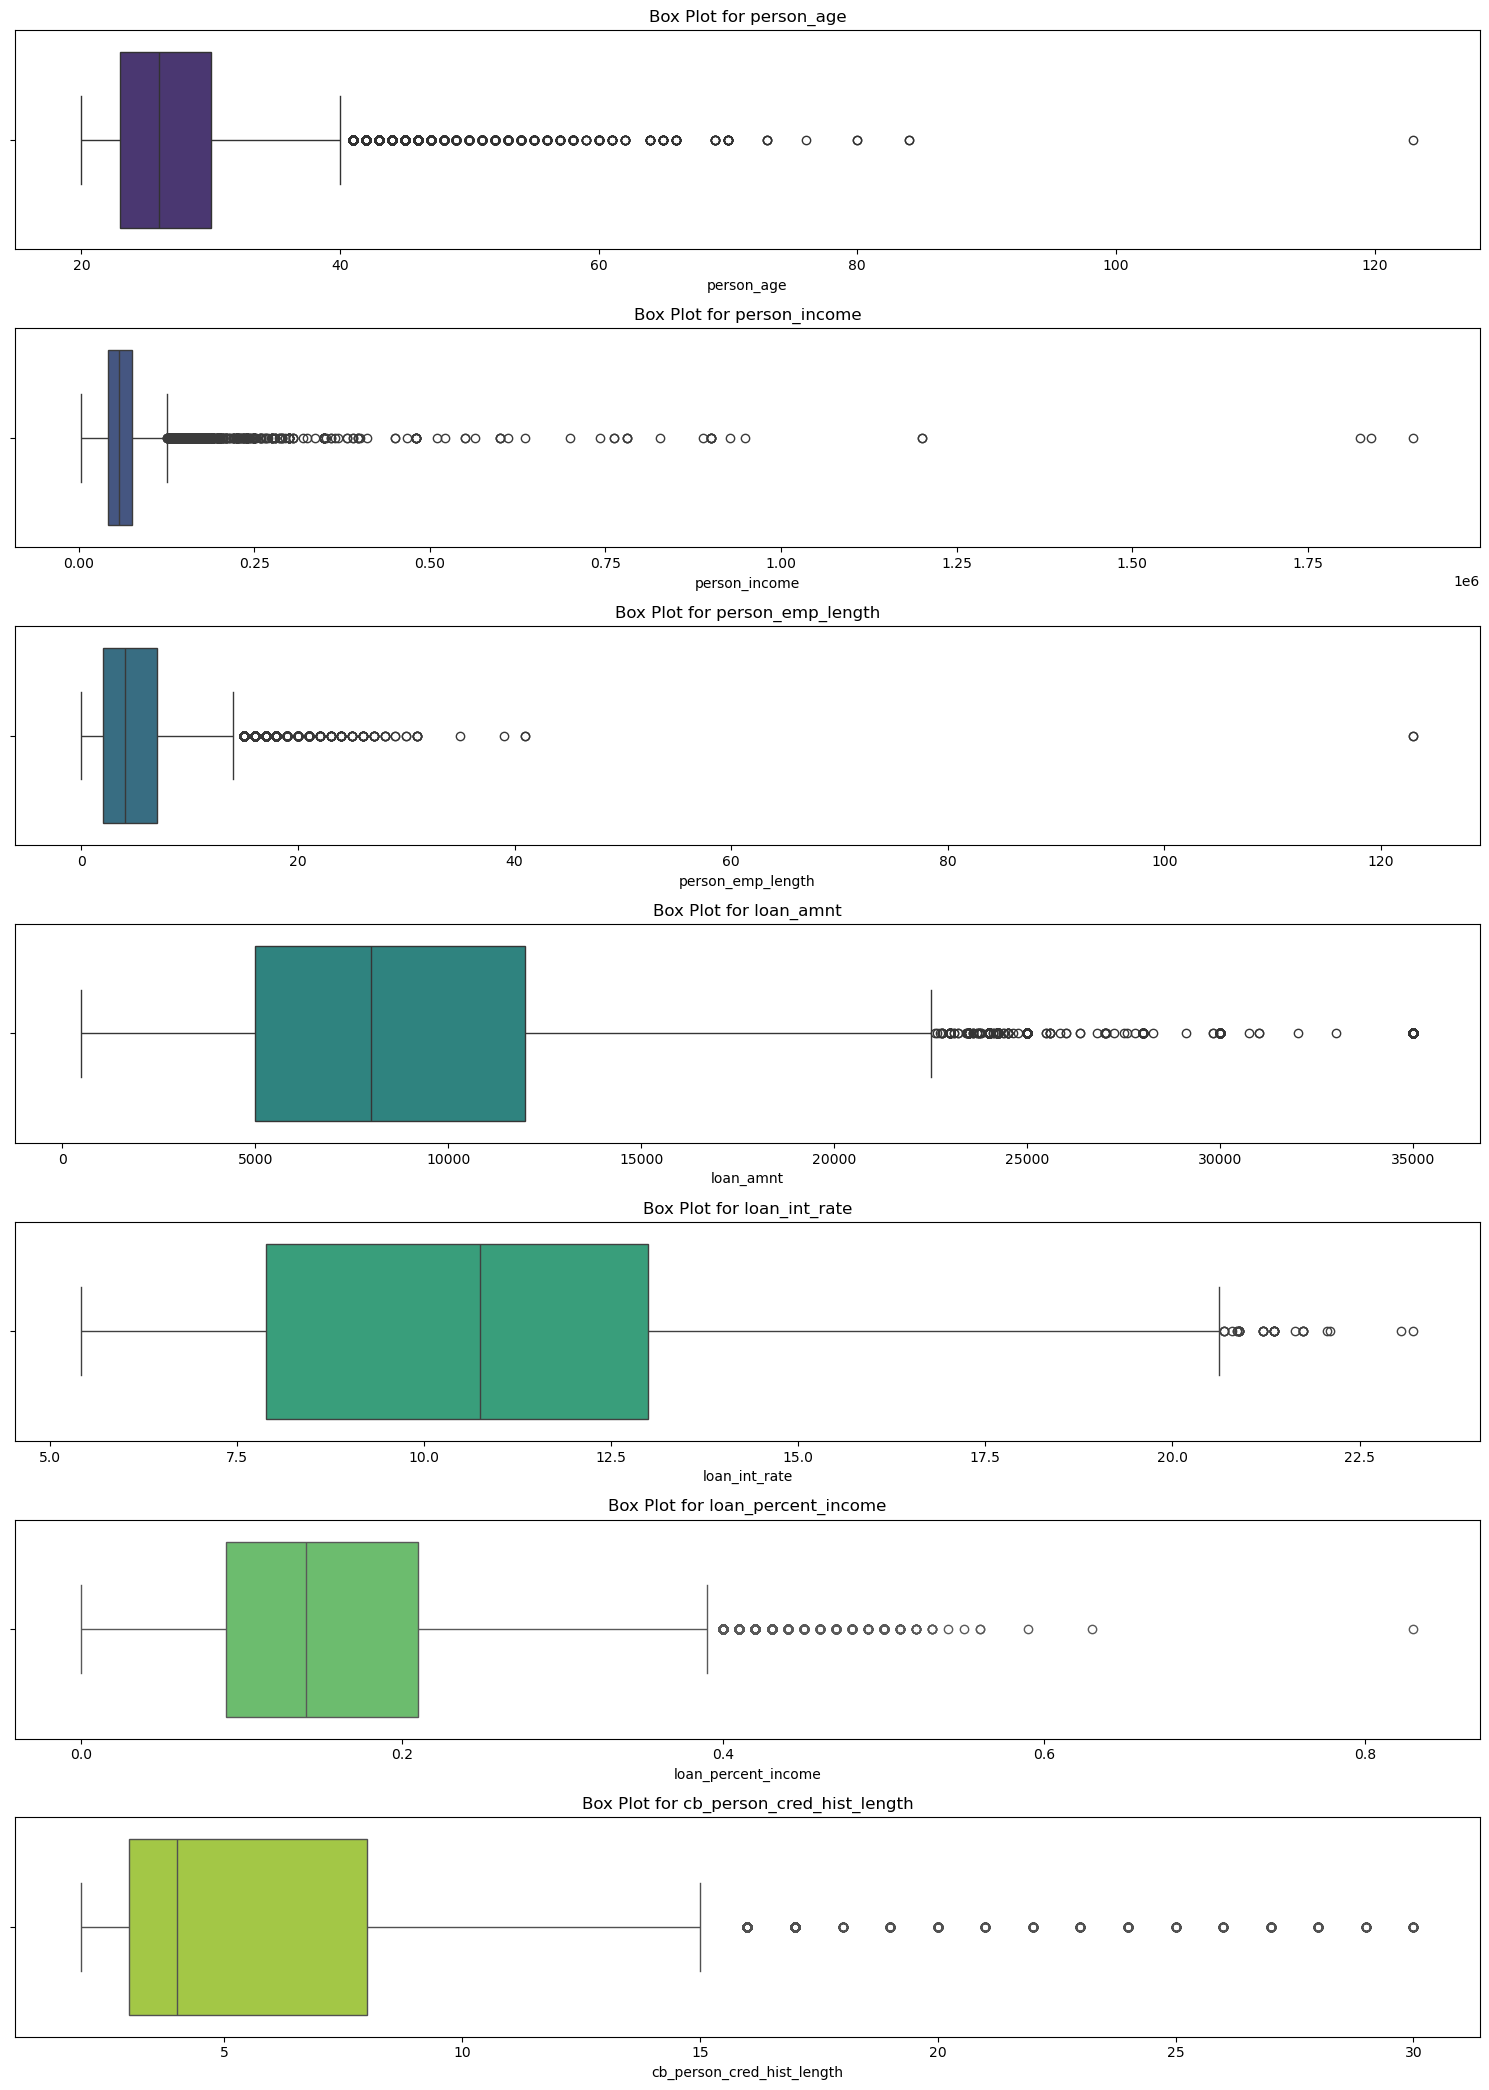

In [19]:
#même chose mais cette fois-ci pour les valeurs abérrantes au travers de boxplots
plt.figure(figsize=(15, len(numerical_cols) * 3))
palette = sns.color_palette("viridis", len(numerical_cols))
for i, (col, color) in enumerate(zip(numerical_cols, palette), 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.boxplot(x=df[col], color=color)
    plt.title(f'Box Plot for {col}')
    plt.tight_layout()
plt.show()

## Pre-processing

##### 1) Supression des outliers

In [21]:
def outliers_iqr(df, cols, factor=1.5):
    """
    Limite les outliers à des seuils basés sur la méthode IQR.
    :param df: DataFrame original
    :param cols: Liste des colonnes numériques où appliquer la méthode
    :param factor: Multiplicateur pour définir les limites (par défaut 1.5)
    :return: DataFrame avec les outliers plafonnés
    """
    # Création d'une copie du DataFrame d'origine pour éviter de le modifier directement
    capped_df = df.copy() 
    for col in cols:
        # Q1 = 25ème percentile pour la colonne col
        Q1 = capped_df[col].quantile(0.25)
        # Q3 = 75ème percentile pour la colonne col
        Q3 = capped_df[col].quantile(0.75)
        # Calcul IQR =  Q3 - Q1
        IQR = Q3 - Q1
        # borne inférieure pour les valeurs acceptables
        lower_bound = Q1 - factor * IQR
        # borne supérieure pour les valeurs acceptables
        upper_bound = Q3 + factor * IQR
        # Limitation (plafonnement) des valeurs de la colonne aux bornes calculées :
        # valeurs inférieures à lower_bound sont remplacées par lower_bound
        # valeurs supérieures à upper_bound sont remplacées par upper_bound
        capped_df[col] = capped_df[col].clip(lower=lower_bound, upper=upper_bound)

    # Retourne le DataFrame avec les valeurs plafonnées dans les colonnes spécifiées
    return capped_df

    
# Supposons que df est votre DataFrame original et numerical_cols vos colonnes numériques
df = outliers_iqr(df, numerical_cols, factor=3.0)

#fonction qui servira à afficher les nouveaux boxplots sans les outliers
def boxplotNum(dataframe, cols):
    plt.figure(figsize=(15, len(cols) * 3))
    for i, col in enumerate(cols, 1):
        plt.subplot(len(cols), 1, i)
        sns.boxplot(x=dataframe[col])
        plt.title(f'Box Plot for {col}')
    plt.tight_layout()
    plt.show()


##### 2)Encodage et Min-Max Normalisation

In [23]:
print(df['loan_grade'].unique()) # me permet de vérifier toutes les valeurs différentes de pour la feature loan_grade avant son encodage
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7} # ensuite j'encode 
df['loan_grade'] = df['loan_grade'].map(grade_mapping) #map permet d'appliquer la ligne de code précédente pour chaque valeur de loan_grade

#j'encode mais cette fois-ci différemment pour toutes les autres features catégoriques (One-Hot) expliqué dans le Bilan
categorical_columns = [
    'person_home_ownership', 
    'loan_intent', 
    'cb_person_default_on_file'
]

df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True) #get_dummies() pour effectuer le one-hot sur chaques categoricals
y = df_encoded['loan_status'].astype(np.float32).values
X = df_encoded.drop('loan_status', axis=1).astype(np.float32).values
df_encoded.head()
print(df_encoded.dtypes)

['B' 'C' 'A' 'D' 'E' 'F' 'G']
person_age                       int64
person_income                    int64
person_emp_length              float64
loan_grade                       int64
loan_amnt                        int64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_cred_hist_length       int64
loan_status                      int64
person_home_ownership_OTHER       bool
person_home_ownership_OWN         bool
person_home_ownership_RENT        bool
loan_intent_EDUCATION             bool
loan_intent_HOMEIMPROVEMENT       bool
loan_intent_MEDICAL               bool
loan_intent_PERSONAL              bool
loan_intent_VENTURE               bool
cb_person_default_on_file_Y       bool
dtype: object


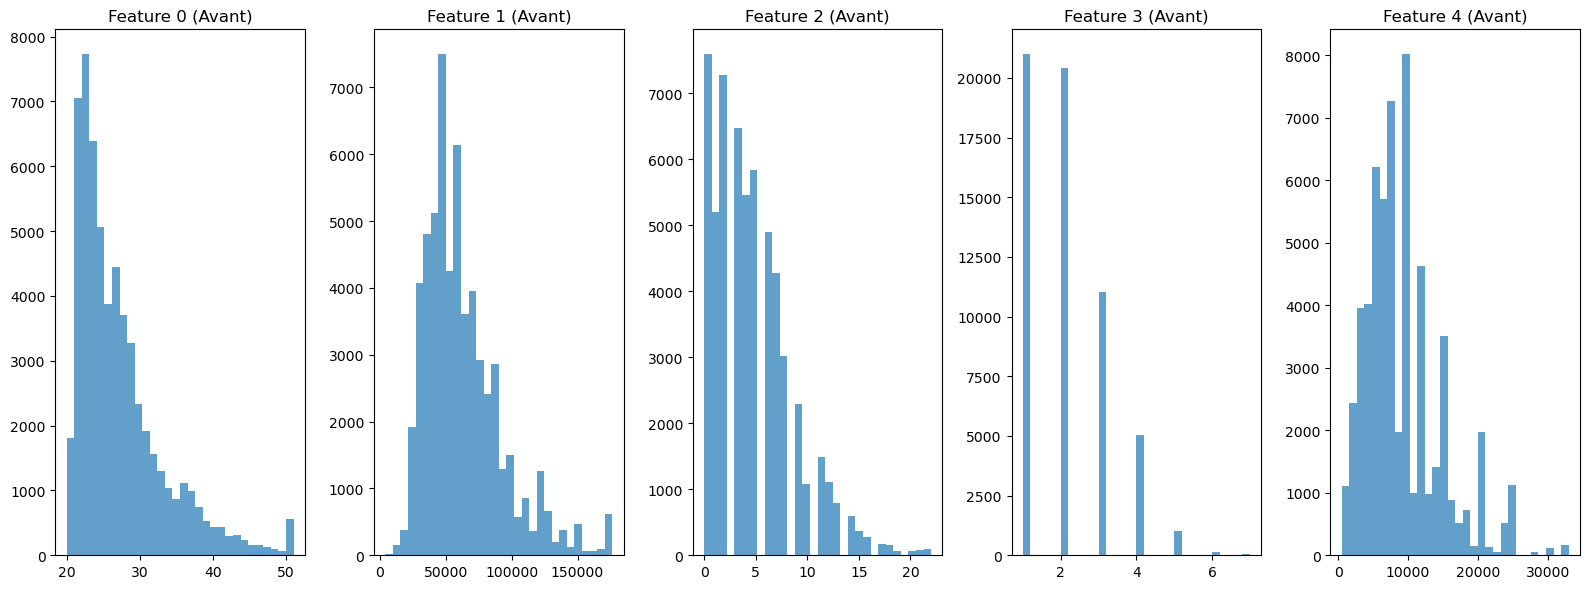

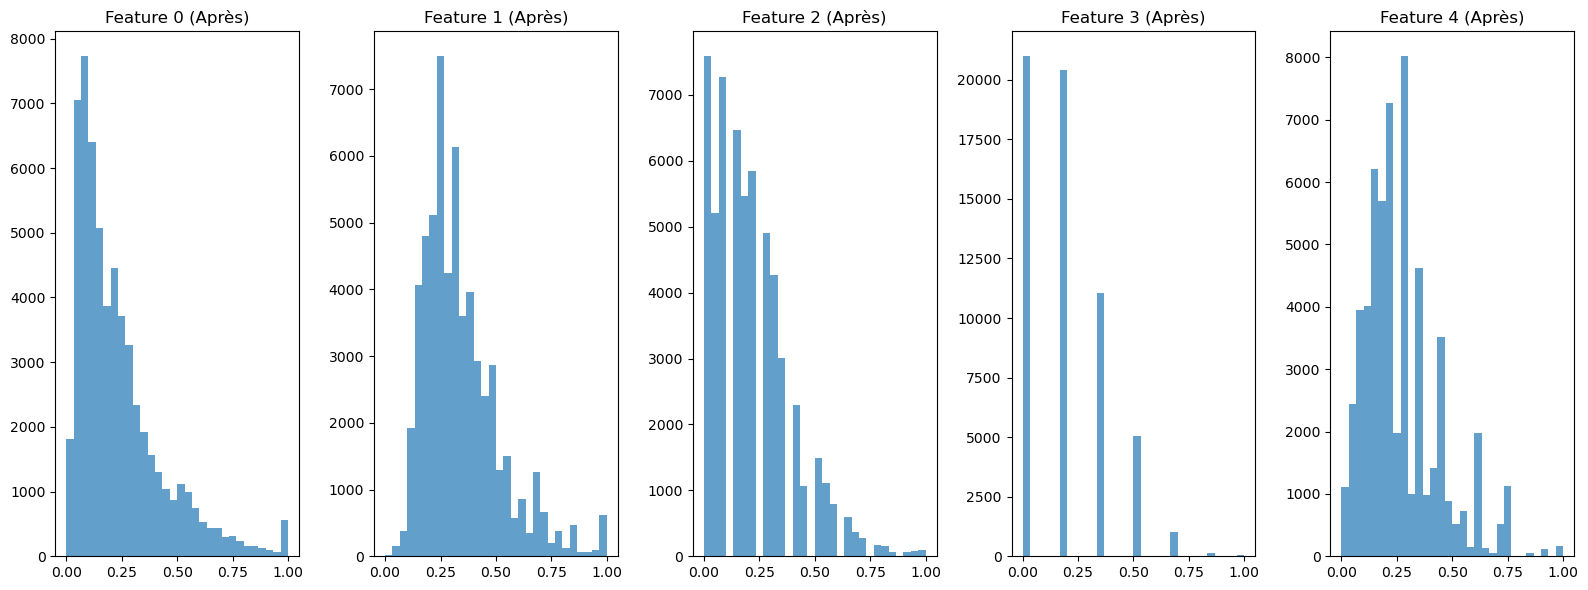

In [25]:
# Stocker les données avant la normalisation
X_before_norm = X.copy()  # Crée une copie des données originales

# Normalisation min-max
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X = (X - X_min) / (X_max - X_min + 1e-8)  # Normalisation appliquée à X

#Comparaison avant et après la normalisation
# Histogrammes avant normalisation
plt.figure(figsize=(16, 6))
for i, col in enumerate(range(X_before_norm.shape[1]), start=1):  # Utiliser X_before_norm
    if i > 5:  # Limiter à 5 features pour simplifier
        break
    plt.subplot(1, 5, i)
    plt.hist(X_before_norm[:, col], bins=30, alpha=0.7, label='Avant Normalisation')
    plt.title(f"Feature {col} (Avant)")
plt.tight_layout()
plt.show()

# Histogrammes après normalisation
plt.figure(figsize=(16, 6))
for i, col in enumerate(range(X.shape[1]), start=1):  # Utiliser X après normalisation
    if i > 5:  # Limiter à 5 features
        break
    plt.subplot(1, 5, i)
    plt.hist(X[:, col], bins=30, alpha=0.7, label='Après Normalisation')
    plt.title(f"Feature {col} (Après)")
plt.tight_layout()
plt.show()


In [27]:
# indices exemples positifs
pos_indices = np.where(y == 1)[0]
# indices exemples négatifs
neg_indices = np.where(y == 0)[0]
# Trouve le nombre minimum entre les exemples positifs et négatifs
# Cela garantit un équilibre parfait entre les deux classes
min_count = min(len(pos_indices), len(neg_indices))
# aléatoire pour garantir que les résultats soient reproductibles
np.random.seed(42)
# aléatoirement min_count indices parmi les positifs
# 'replace=False' empêche de sélectionner plusieurs fois le même indice
chosen_pos = np.random.choice(pos_indices, size=min_count, replace=False)
# aléatoirement min_count indices parmi les négatifs
chosen_neg = np.random.choice(neg_indices, size=min_count, replace=False)
#indices en une seule liste
balanced_indices = np.concatenate([chosen_pos, chosen_neg])
# mélange l'ordre de la liste d'indices
np.random.shuffle(balanced_indices)
#jeux de données equilibrés et etiquettes 
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]


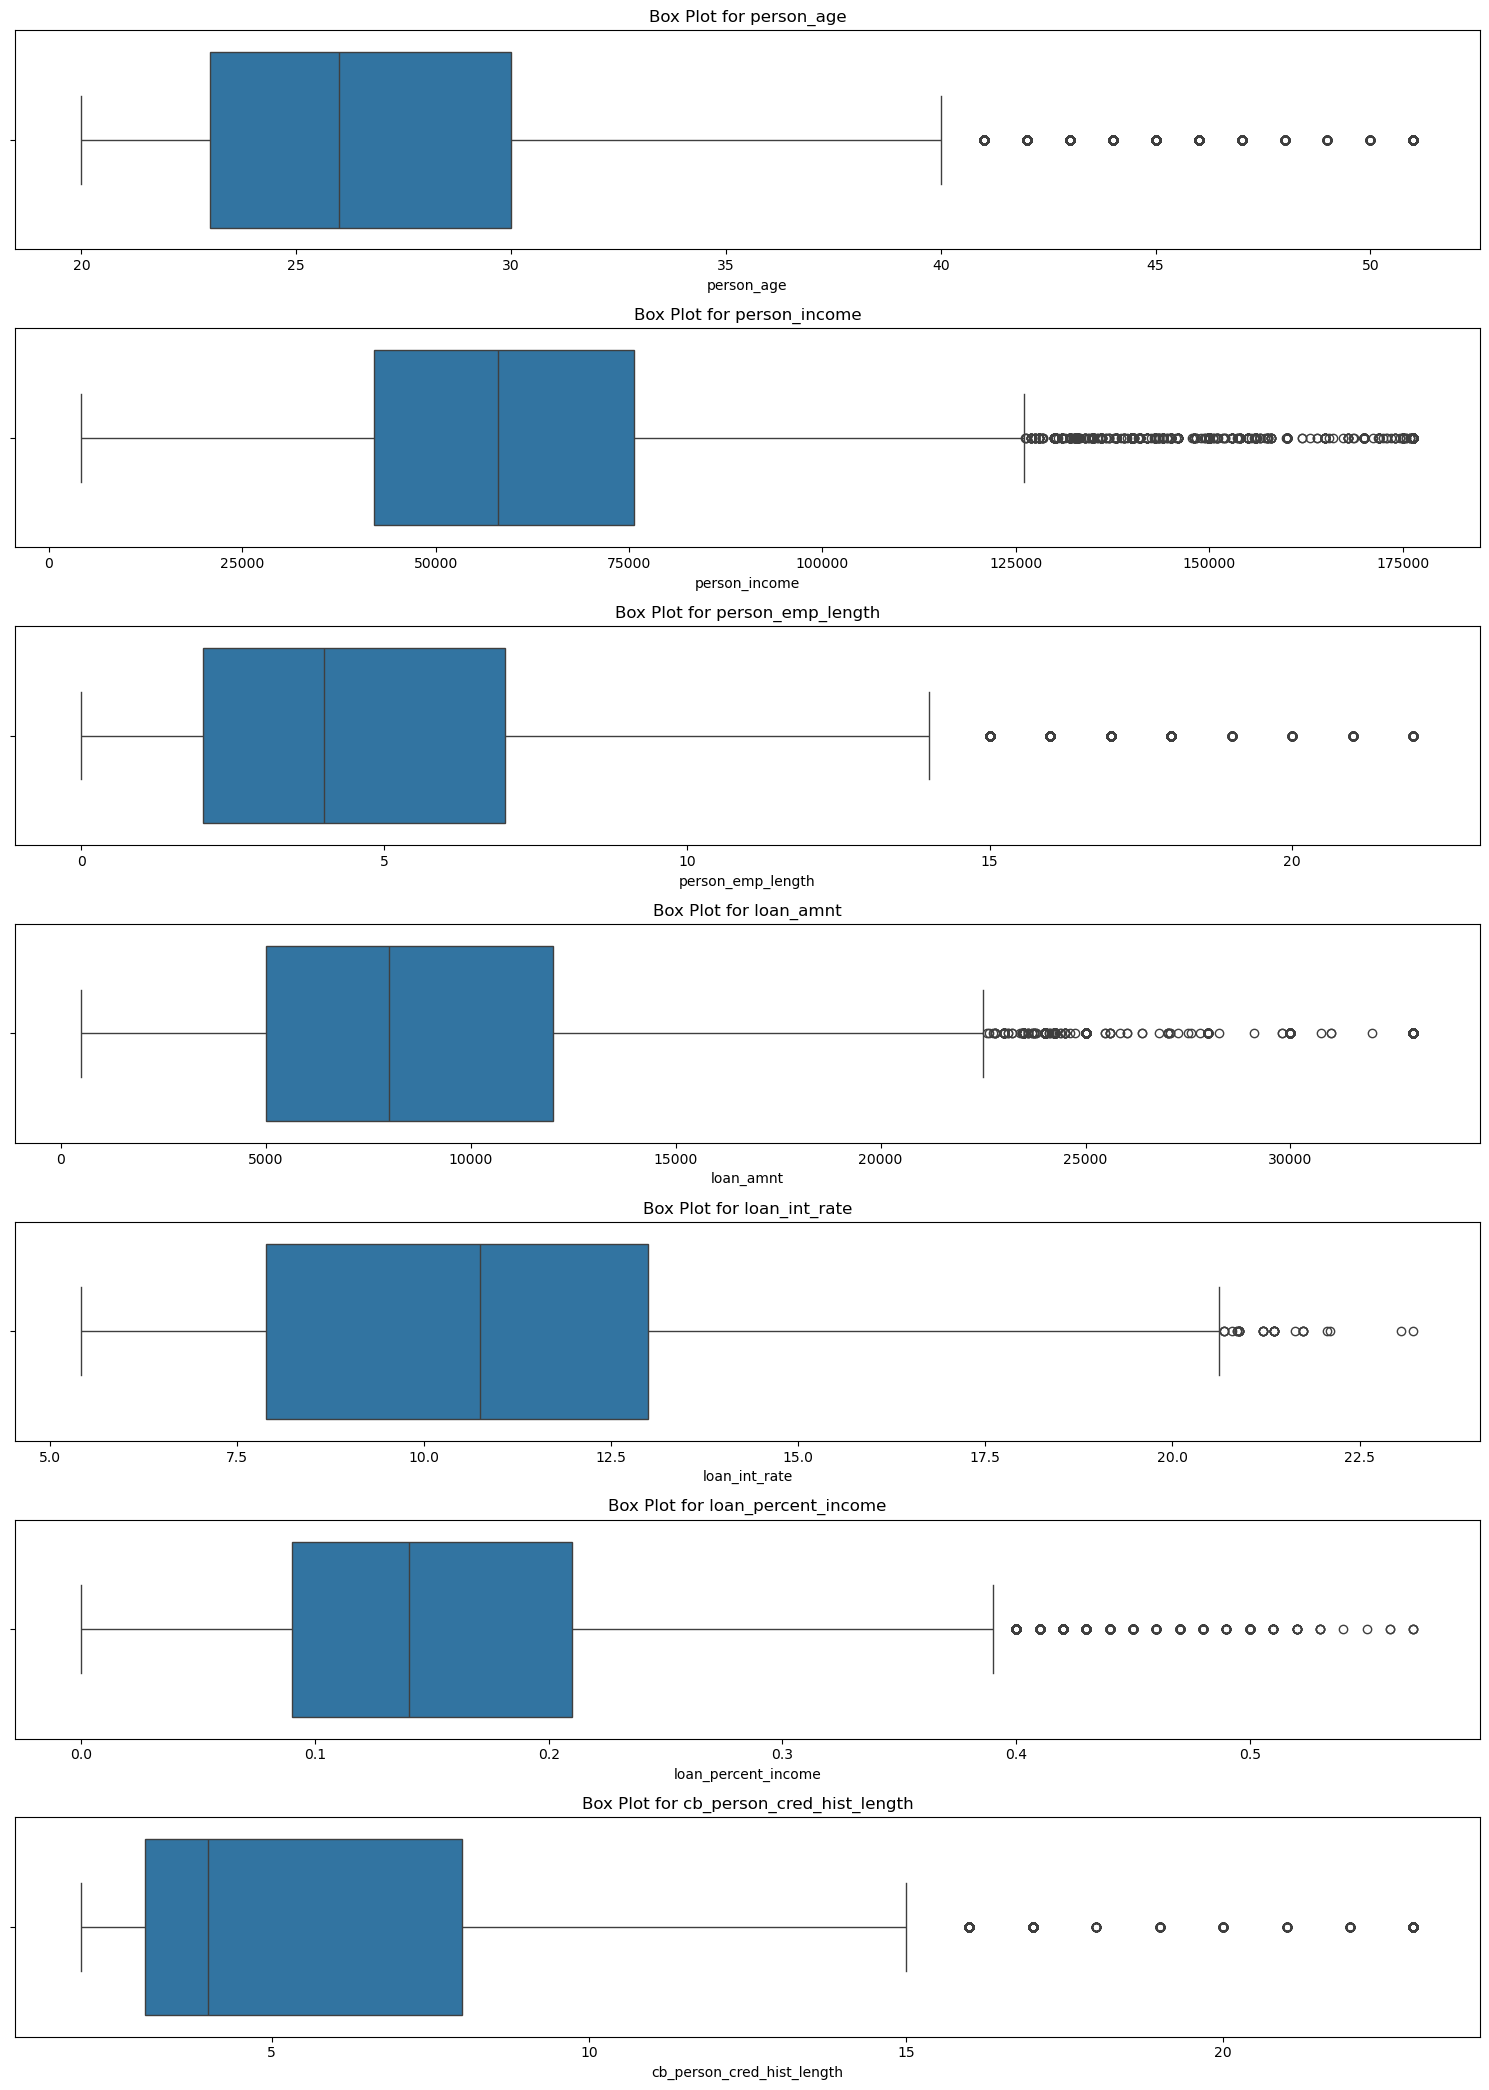

In [29]:
boxplotNum(df, numerical_cols) # pour voir les outliers

##### exemple avant/après équilibrage

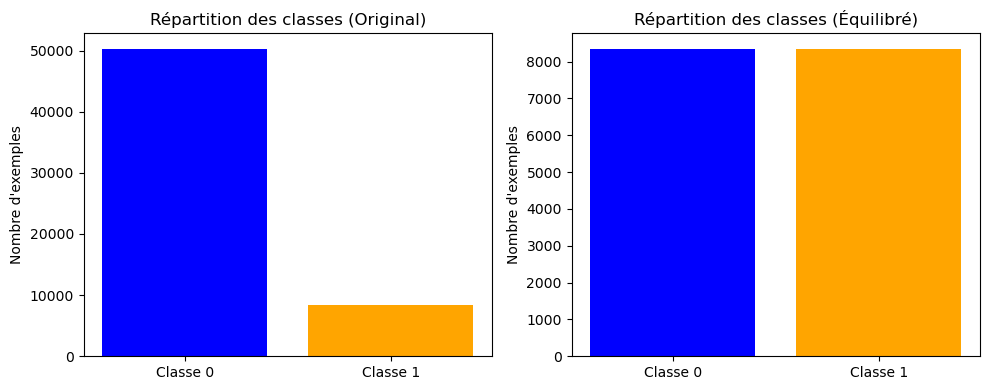

In [31]:
# Avant équilibrage
original_pos_count = (y == 1).sum()
original_neg_count = (y == 0).sum()

# Après équilibrage
balanced_pos_count = (y_balanced == 1).sum()
balanced_neg_count = (y_balanced == 0).sum()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(['Classe 0', 'Classe 1'], [original_neg_count, original_pos_count], color=['blue', 'orange'])
plt.title("Répartition des classes (Original)")
plt.ylabel("Nombre d'exemples")

# le dataset équilibré
plt.subplot(1, 2, 2)
plt.bar(['Classe 0', 'Classe 1'], [balanced_neg_count, balanced_pos_count], color=['blue', 'orange'])
plt.title("Répartition des classes (Équilibré)")
plt.ylabel("Nombre d'exemples")

plt.tight_layout()
plt.show()


In [33]:
#split
#vu en cours donc je ne commente pas, mais le code permet de séparer en train et validation pour entrainer et valider les modèles
n_samples = X_balanced.shape[0]
train_size = int(0.8 * n_samples)
indices = np.random.permutation(n_samples)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

X_train, y_train = X_balanced[train_indices], y_balanced[train_indices]
X_val, y_val = X_balanced[val_indices], y_balanced[val_indices]

In [35]:
# Calcule le nombre d'occurrences de chaque classe dans y_balanced
class_counts = np.bincount(y_balanced.astype(int))
# Nombre de la classe négative 0
neg_count = class_counts[0]
# Nombre de la classe positive 1
# 1 est absente, on évite une erreur en définissant pos_count à 1
pos_count = class_counts[1] if len(class_counts) > 1 else 1
# calcul poids pour la classe positive afin de compenser le déséquilibre des classes
# Le terme (1e-8) est ajouté pour éviter une division par zéro, (trouvé grâce à internet car je ne trouvais pas)
pos_weight = torch.tensor([neg_count / (pos_count + 1e-8)], dtype=torch.float32)


### Pipeline et implémentation des modèles

##### Définitions des deux modèles 

In [37]:
#code détaillé et expliqué dans le bilan
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)

##### Métriques AUC/ROC et accuracy

In [39]:
def accuracy(y_logits, y_true):
    probs = torch.sigmoid(y_logits) # applique la sigmoid sur les y_logits (sorties brutes des modèles)
    preds = (probs >= 0.5).float() # definis la prédiction si au seuil de 0.5 > proba => pred = 1 else 0
    return (preds == y_true).float().mean() # calcul le rapport TP + TN / TOTAL 

#la fonction compute roc_auc trouvé sur internet car je ne savais pas comment la recoder sans utiliser sklearn.metrics
#de plus elle est un bonus puisqu'elle est purement informative, j'ai regardé sur internet pour comprendre comment et à quoi elle sert
def compute_roc_auc(y_true, y_score):
    # Tri par ordre décroissant
    order = np.argsort(y_score)[::-1]
    y_true = y_true[order]
    y_score = y_score[order]

    pos = (y_true == 1).sum()
    neg = (y_true == 0).sum()

    TP, FP = 0, 0
    tpr_vals = [0.0]
    fpr_vals = [0.0]

    for i in range(y_true.shape[0]):
        if y_true[i] == 1:
            TP +=1
        else:
            FP +=1
        tpr_vals.append(TP / pos if pos > 0 else 0)
        fpr_vals.append(FP / neg if neg > 0 else 0)

    auc=0.0
    for i in range(1, len(tpr_vals)):
        auc += (fpr_vals[i]-fpr_vals[i-1])*(tpr_vals[i]+tpr_vals[i-1])/2.0
    return auc


##### Entrainement

In [41]:
def train_model(model, X, y, pos_weight, epochs=100, batch_size=64, lr=1e-3, l2_lambda=1e-4):
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #conversion en tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    best_auc = 0.0 #initialise pour la meilleure val de auc
    
    # Stockage des métriques
    epoch_list = []
    loss_list = []
    auc_list = []
    acc_list = []
    
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_tensor.size(0))
        epoch_loss = 0.0
        for i in range(0, X_tensor.size(0), batch_size):
            idx = permutation[i:i+batch_size]
            batch_X, batch_y = X_tensor[idx], y_tensor[idx]

            optimizer.zero_grad()
            out = model(batch_X)

            # L2 régularisation
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = criterion(out, batch_y) + l2_lambda * l2_norm

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Évaluation sur le train
        model.eval()
        with torch.no_grad():
            train_out = model(X_tensor)
            train_acc = accuracy(train_out, y_tensor).item()
            train_probs = torch.sigmoid(train_out).numpy().squeeze()
            train_auc = compute_roc_auc(y_tensor.numpy().squeeze(), train_probs)

        if train_auc > best_auc:
            best_auc = train_auc

        # Stockage des métriques par epoch
        epoch_list.append(epoch+1)
        loss_list.append(epoch_loss)
        auc_list.append(train_auc)
        acc_list.append(train_acc)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Train Acc: {train_acc*100:.2f}%, "
              f"Train AUC: {train_auc:.4f}")

    print("Meilleure AUC obtenue sur le train:", best_auc)
    return epoch_list, loss_list, auc_list, acc_list, best_auc

In [43]:
#comparaison des deux modèles
input_dim = X_balanced.shape[1]

print("=== Entraînement du modèle de régression logistique (rééquilibré) ===")
lr_model = LogisticRegressionModel(input_dim)
lr_epochs, lr_loss, lr_auc, lr_acc, lr_best_auc = train_model(lr_model, X_balanced, y_balanced, pos_weight, epochs=100)

print("\n=== Entraînement du modèle MLP (rééquilibré) ===")
mlp_model = SimpleMLP(input_dim)
mlp_epochs, mlp_loss, mlp_auc, mlp_acc, mlp_best_auc = train_model(mlp_model, X_balanced, y_balanced, pos_weight, epochs=100)

=== Entraînement du modèle de régression logistique (rééquilibré) ===
Epoch 1/100, Train Loss: 168.2695, Train Acc: 71.69%, Train AUC: 0.8103
Epoch 2/100, Train Loss: 156.0006, Train Acc: 74.68%, Train AUC: 0.8342
Epoch 3/100, Train Loss: 147.5466, Train Acc: 75.97%, Train AUC: 0.8449
Epoch 4/100, Train Loss: 141.4094, Train Acc: 76.91%, Train AUC: 0.8519
Epoch 5/100, Train Loss: 136.7385, Train Acc: 77.43%, Train AUC: 0.8577
Epoch 6/100, Train Loss: 133.0119, Train Acc: 78.07%, Train AUC: 0.8626
Epoch 7/100, Train Loss: 129.9549, Train Acc: 78.57%, Train AUC: 0.8668
Epoch 8/100, Train Loss: 127.4010, Train Acc: 78.92%, Train AUC: 0.8704
Epoch 9/100, Train Loss: 125.2599, Train Acc: 79.19%, Train AUC: 0.8735
Epoch 10/100, Train Loss: 123.3913, Train Acc: 79.39%, Train AUC: 0.8763
Epoch 11/100, Train Loss: 121.7848, Train Acc: 79.59%, Train AUC: 0.8786
Epoch 12/100, Train Loss: 120.3960, Train Acc: 79.72%, Train AUC: 0.8805
Epoch 13/100, Train Loss: 119.1610, Train Acc: 80.13%, Train AU

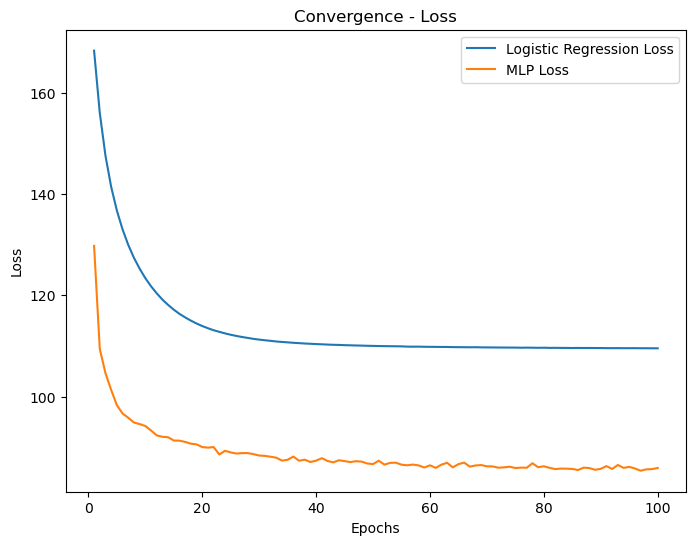

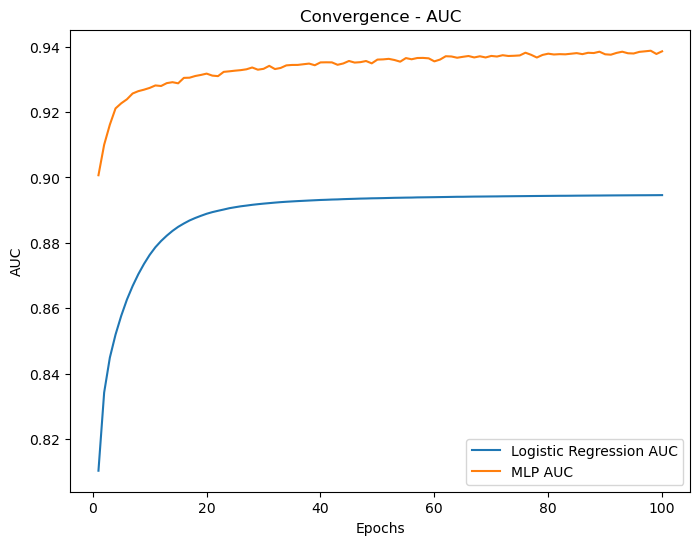

In [45]:

#convergence de la loss et de l'auc 
plt.figure(figsize=(8,6))
plt.plot(lr_epochs, lr_loss, label='Logistic Regression Loss')
plt.plot(mlp_epochs, mlp_loss, label='MLP Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Convergence - Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(lr_epochs, lr_auc, label='Logistic Regression AUC')
plt.plot(mlp_epochs, mlp_auc, label='MLP AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Convergence - AUC')
plt.legend()
plt.show()



In [47]:

#tentative de hyperparam-tuning 
# j'ai essayé de tester différents learning rate pour les modèle, exemple ici avec le MLP mais il y a pleins d'autres choses à tester, voir explications bilan
best_lr = None
best_lr_auc = 0.0

for lr_test in [1e-2, 1e-3, 1e-4]:
    print(f"Test LR = {lr_test}")
    temp_model = SimpleMLP(input_dim)
    _, _, _, _, auc_val = train_model(temp_model, X_balanced, y_balanced, pos_weight, epochs=50, lr=lr_test)
    if auc_val > best_lr_auc:
        best_lr_auc = auc_val
        best_lr = lr_test

print(f"Meilleur LR trouvé : {best_lr} avec AUC = {best_lr_auc}")


Test LR = 0.01
Epoch 1/50, Train Loss: 115.2679, Train Acc: 84.13%, Train AUC: 0.9185
Epoch 2/50, Train Loss: 102.4573, Train Acc: 84.77%, Train AUC: 0.9210
Epoch 3/50, Train Loss: 101.2905, Train Acc: 85.29%, Train AUC: 0.9239
Epoch 4/50, Train Loss: 100.5632, Train Acc: 85.28%, Train AUC: 0.9247
Epoch 5/50, Train Loss: 100.1616, Train Acc: 85.13%, Train AUC: 0.9257
Epoch 6/50, Train Loss: 99.0362, Train Acc: 85.18%, Train AUC: 0.9256
Epoch 7/50, Train Loss: 98.3982, Train Acc: 85.47%, Train AUC: 0.9272
Epoch 8/50, Train Loss: 98.5044, Train Acc: 84.86%, Train AUC: 0.9259
Epoch 9/50, Train Loss: 98.3469, Train Acc: 85.51%, Train AUC: 0.9270
Epoch 10/50, Train Loss: 98.6971, Train Acc: 85.30%, Train AUC: 0.9265
Epoch 11/50, Train Loss: 98.0709, Train Acc: 85.56%, Train AUC: 0.9276
Epoch 12/50, Train Loss: 97.4301, Train Acc: 85.57%, Train AUC: 0.9259
Epoch 13/50, Train Loss: 98.1213, Train Acc: 84.57%, Train AUC: 0.9266
Epoch 14/50, Train Loss: 97.9793, Train Acc: 85.92%, Train AUC: 0.

### Kaggle Soumission

In [49]:
#  - On suppose un fichier test.csv avec les mêmes colonnes
#  - On refait le même pré-traitement : encodage de loan_grade, one-hot, normalisation
#  - On génère les prédictions avec le meilleur modèle, MLP

df_test = pd.read_csv('/home/m1000/Bureau/playground-series-s4e10/test.csv')
test_ids = df_test['id']
del df_test['id']

# Encodage loan_grade
df_test['loan_grade'] = df_test['loan_grade'].map(grade_mapping)

# One-hot pour test
# On refait un dummy encode puis on aligne les colonnes.
test_encoded = pd.get_dummies(df_test, columns=categorical_columns, drop_first=True)

# On peut trouver les colonnes manquantes et les ajouter
train_cols = df_encoded.drop('loan_status', axis=1).columns
for col in train_cols:
    if col not in test_encoded.columns:
        test_encoded[col] = 0
test_encoded = test_encoded[train_cols]  # Réordonnancement pour correspondre exactement

# Normalisation avec les même min/max que le train
X_test = test_encoded.values.astype(np.float32)
X_test = (X_test - X_min) / (X_max - X_min + 1e-8)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Utiliser le modèle MLP entraîné
mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(X_test_tensor)
    probs = torch.sigmoid(logits).numpy().squeeze()

# On choisit un seuil 0.5 pour la soumission
predictions = (probs >= 0.5).astype(int)

submission = pd.DataFrame({
    'id': test_ids,
    'loan_status': predictions
})

submission.to_csv('submission.csv', index=False)

print("Fichier de soumission 'submission.csv' généré.")


#Suite sur le NEF

Fichier de soumission 'submission.csv' généré.


### FIN/Merci, Bilan disponible dans le dossier joint pour des analyses plus précises, questions: marius.casamian@etu.unice.fr